In [7]:
PATH_data_source = "../data/source/"
PATH_data_output = "../data/output/"
PATH_model = "../model/"

In [9]:
import pandas as pd
import numpy as np
import shap
import sklearn
import tensorflow as tf  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import math

from aif360.sklearn.metrics import (
    equal_opportunity_difference,
    statistical_parity_difference,
    average_odds_difference,
    disparate_impact_ratio,
    between_group_generalized_entropy_error
)

In [11]:
import sys
sys.path.append("../code/")
from utils import split_df_upper_lower_half


In [13]:
file_name = 'BangladeshiDiabetesRiskAssessment'
df = pd.read_csv(PATH_data_source + file_name + ".csv")
df

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Female,Yes,Yes,Yes,No,Yes,No,No,Yes,No,Yes,Yes,No,No,No,Positive
516,48,Female,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,Positive
517,58,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Positive
518,32,Female,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,No,Yes,No,Negative


# Attack using Gender only

### Preprocess 
- select scoring features
- select protected features
- define baseline scoring function

In [17]:
X = df.drop(['class', 'Age'], axis=1)
X['Gender'] = X['Gender'].replace({'Male': 1, 'Female': 0})
X = X.replace({'Yes': 1, 'No': 0})
x = X.drop(['Gender'], axis=1)

C:\Users\user\AppData\Local\Temp\ipykernel_9856\732273555.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['Gender'] = X['Gender'].replace({'Male': 1, 'Female': 0})
C:\Users\user\AppData\Local\Temp\ipykernel_9856\732273555.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({'Yes': 1, 'No': 0})


In [19]:
y = df['class'].replace({'Positive': 1, 'Negative': 0})  

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train Neural Network
model_nn = Sequential([
    Dense(32, activation='relu', input_dim=x_train.shape[1]),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_nn.fit(x_train, y_train, epochs=50, batch_size=8, verbose=1)

# Model Evaluation
predictions = (model_nn.predict(x_test) > 0.5).astype(int)  
print("Classification Report:")
print(classification_report(y_test, predictions))

C:\Users\user\AppData\Local\Temp\ipykernel_9856\1251388356.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['class'].replace({'Positive': 1, 'Negative': 0})
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4307 - loss: 0.7746
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5994 - loss: 0.5442
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.4437
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8938 - loss: 0.3327
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8611 - loss: 0.3015
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9108 - loss: 0.2381
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9302 - loss: 0.2198
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9084 - loss: 0.2484
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9127 - loss: 0.2342
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9381 - loss: 0.2022
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9308 - loss: 0.2101
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9341 - lo

In [21]:
def f(x):
    xx = pd.DataFrame(x[:, 1:])
    xx.columns = ['Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness',
                  'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching',
                  'Irritability', 'delayed healing', 'partial paresis',
                  'muscle stiffness', 'Alopecia', 'Obesity']
    return model_nn.predict(xx).flatten()  

# Preprocess for Attacks
def preprocess(x):
    df = pd.DataFrame(x)
    df.columns = ['protected_attr', *df.columns[1:]]
    df['index'] = df.index
    df['s'] = f(x)
    df = df.sort_values(by=['s'], ascending=False)
    df_score_swap = df[['s', 'protected_attr', 'index']].reset_index(drop=True)
    return df_score_swap

In [23]:
exec(open("../code/domSwapAttack.py").read())
exec(open("../code/mixSwapAttack.py").read())

In [25]:
model = MixSwapAttack_g

## fairness metrics calculate 


In [28]:
def get_data_test_grouped(group=['Gender', 'Age']):
    yy = df[['Gender', 'Age', 'class']]
    yy_train, yy_test = train_test_split(yy, test_size=0.2, random_state=0)
    y_test_g = yy_test[['Gender', 'Age', 'class']]
    y_test_g['Age'] = y_test_g['Age'] < df['Age'].median()
    y_test_g['Age'] = y_test_g['Age'].astype(int)
    y_test_g['class'] = y_test_g['class'].map({'Positive': 1, 'Negative': 0})
    y_test_g['Gender'] = y_test_g['Gender'].map({'Male': 1, 'Female': 0})
    return y_test_g

def get_data_pred_origin_shuffled(X_test, x_test, threshold):
    y_pred_shuffled = model(X_test.values) > threshold
    y_pred_shuffled = np.array([1 if e else 0 for e in y_pred_shuffled])
    y_pred = (model_nn.predict(x_test) > threshold).astype(int).flatten()  
    return y_pred, y_pred_shuffled

def calc_fair_metrics(y_test, y_pred, priv_group=(1, 1)):
    return {
        "Equal Opportunity": equal_opportunity_difference(y_test, y_pred, priv_group=priv_group),
        "Demographic Parity": statistical_parity_difference(y_test, y_pred, priv_group=priv_group),
        "Equal Odds": average_odds_difference(y_test, y_pred, priv_group=priv_group),
        "Disparate Impact": disparate_impact_ratio(y_test, y_pred, priv_group=priv_group),
        "Theil Index": between_group_generalized_entropy_error(y_test, y_pred, priv_group=priv_group, alpha=1)
    }

def get_fairness_data(X_test, x_test, threshold, priv_group=['Gender', 'Age']):
    y_pred, y_pred_shuffled = get_data_pred_origin_shuffled(X_test, x_test, threshold)
    y_test_g = get_data_test_grouped(group=priv_group)
    if priv_group == ['Gender', 'Age']:
        pg = (1, 1)
    elif priv_group == ['Gender']:
        pg = (1)
        y_test_g = y_test_g.drop(['Age'], axis=1)
    else:
        pg = (1)
        y_test_g = y_test_g.drop(['Gender'], axis=1)

    y_test_g = y_test_g.set_index(priv_group)
    return {
        'origin': calc_fair_metrics(y_test_g.squeeze(), y_pred, priv_group=pg),
        'shuffled': calc_fair_metrics(y_test_g.squeeze(), y_pred_shuffled, priv_group=pg)
    }

In [30]:
get_fairness_data(X_test, x_test, threshold=0.9, priv_group=['Gender'])


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
score swap data here
swapping happened 41 times
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


C:\Users\user\Desktop\the product\shapFooling - neural nets\experiments\../code\utils.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[i1, :], df.iloc[i2, :] = b, a


{'origin': {'Equal Opportunity': -0.02941176470588236,
  'Demographic Parity': 0.49358178053830226,
  'Equal Odds': -0.02752639517345401,
  'Disparate Impact': 2.0986175115207373,
  'Theil Index': 0.0002080323841961603},
 'shuffled': {'Equal Opportunity': 0.07058823529411762,
  'Demographic Parity': 0.49358178053830226,
  'Equal Odds': -0.015987933634992457,
  'Disparate Impact': 2.0986175115207373,
  'Theil Index': 0.0002080323841961603}}

## Explain the attack function using SHAP

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 702 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 740 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 784 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 752 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 748 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 762 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 782 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 758 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 746 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 655 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 706 times
53/53 ━━━━━━━━━━━━━━━━━

PermutationExplainer explainer:   1%|▌                                                         | 1/104 [00:00<?, ?it/s]

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 618 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 615 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 615 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 602 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 613 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 598 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 616 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 614 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 610 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 621 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 625 times
44/44 ━━━━━━━━━━━━━━━━━━━━

PermutationExplainer explainer:   3%|█▍                                                | 3/104 [00:37<13:22,  7.94s/it]

swapping happened 463 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 465 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 471 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 387 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 478 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 339 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 433 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 473 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 478 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 444 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 431 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 433 

PermutationExplainer explainer:   4%|█▉                                                | 4/104 [00:49<16:19,  9.80s/it]

swapping happened 496 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 615 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 587 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 538 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 566 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 602 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 612 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 551 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 561 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 490 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 608 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 507 t

PermutationExplainer explainer:   5%|██▍                                               | 5/104 [01:06<20:28, 12.41s/it]

swapping happened 366 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 604 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 630 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 630 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 629 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 634 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 609 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 610 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 617 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 583 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 597 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 595 

PermutationExplainer explainer:   6%|██▉                                               | 6/104 [01:22<22:15, 13.62s/it]

swapping happened 414 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 589 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 580 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 568 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 618 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 592 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 620 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 602 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 594 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 568 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 599 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 613

PermutationExplainer explainer:   7%|███▎                                              | 7/104 [01:40<24:32, 15.18s/it]

swapping happened 469 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 565 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 562 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 556 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 549 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 565 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 545 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 562 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 559 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 532 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 577 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 539

PermutationExplainer explainer:   8%|███▊                                              | 8/104 [01:55<24:02, 15.02s/it]

swapping happened 423 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 714 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 666 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 714 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 707 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 619 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 700 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 704 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 668 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 631 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 704 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 676

PermutationExplainer explainer:   9%|████▎                                             | 9/104 [02:12<24:47, 15.65s/it]

swapping happened 499 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 709 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 676 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 626 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 603 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 705 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 677 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 639 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 718 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 662 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 544 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 733 ti

PermutationExplainer explainer:  10%|████▋                                            | 10/104 [02:29<25:10, 16.07s/it]

swapping happened 500 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 426 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 375 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 433 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 448 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 347 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 356 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 341 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 472 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 448 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 400 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 403

PermutationExplainer explainer:  11%|█████▏                                           | 11/104 [02:41<22:59, 14.83s/it]

swapping happened 475 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 606 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 602 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 618 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 595 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 697 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 645 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 687 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 576 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 578 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 595 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 639

PermutationExplainer explainer:  12%|█████▋                                           | 12/104 [02:58<23:31, 15.34s/it]

swapping happened 441 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 620 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 565 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 547 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 615 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 608 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 618 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 593 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 641 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 607 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 617 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 607 t

PermutationExplainer explainer:  12%|██████▏                                          | 13/104 [03:13<23:26, 15.46s/it]

swapping happened 388 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 748 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 798 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 746 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
score swap data here
swapping happened 708 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 716 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 769 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 758 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 752 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
score swap data here
swapping happened 680 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
score swap data here
swapping happened 682 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 7

PermutationExplainer explainer:  13%|██████▌                                          | 14/104 [03:32<24:46, 16.51s/it]

swapping happened 557 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 375 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 381 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 290 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 376 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 358 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 329 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 362 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 399 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 312 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 387 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 294 

PermutationExplainer explainer:  14%|███████                                          | 15/104 [03:44<22:25, 15.12s/it]

swapping happened 423 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 523 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 576 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 538 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 563 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 574 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 548 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 582 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 571 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 561 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 547 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 554 

PermutationExplainer explainer:  15%|███████▌                                         | 16/104 [04:00<22:32, 15.37s/it]

swapping happened 448 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 310 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 459 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 456 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 489 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 469 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 328 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 348 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 372 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 316 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 404 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 419 

PermutationExplainer explainer:  16%|████████                                         | 17/104 [04:12<20:40, 14.25s/it]

swapping happened 461 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 723 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 617 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 691 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 673 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 730 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 658 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 628 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 696 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 691 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 733 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 629

PermutationExplainer explainer:  17%|████████▍                                        | 18/104 [04:29<21:52, 15.26s/it]

swapping happened 474 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 823 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 725 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 770 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 756 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 744 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 745 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 784 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 734 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 731 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 773 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 811 times

PermutationExplainer explainer:  18%|████████▉                                        | 19/104 [04:49<23:38, 16.69s/it]

swapping happened 543 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 694 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 717 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 700 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 721 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 690 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 692 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 639 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 694 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 635 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 711 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 703 ti

PermutationExplainer explainer:  19%|█████████▍                                       | 20/104 [05:08<24:13, 17.30s/it]

swapping happened 507 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 389 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 464 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 361 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 425 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 405 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 505 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 427 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 447 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 470 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 447 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 413

PermutationExplainer explainer:  20%|█████████▉                                       | 21/104 [05:20<21:33, 15.58s/it]

swapping happened 457 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 665 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 707 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 683 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 697 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 701 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 702 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 695 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 667 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 659 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 681 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 678 ti

PermutationExplainer explainer:  21%|██████████▎                                      | 22/104 [05:39<22:55, 16.77s/it]

swapping happened 504 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 315 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 309 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 364 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 266 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 332 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 278 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 332 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 246 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 282 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 350 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 268

PermutationExplainer explainer:  22%|██████████▊                                      | 23/104 [05:49<19:45, 14.64s/it]

swapping happened 411 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 371 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
score swap data here
swapping happened 428 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 367 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 430 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 382 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
score swap data here
swapping happened 364 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 355 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 376 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 341 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 426 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 38

PermutationExplainer explainer:  23%|███████████▎                                     | 24/104 [06:03<19:06, 14.33s/it]

swapping happened 495 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 506 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 479 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 515 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 584 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
score swap data here
swapping happened 572 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 584 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 472 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 536 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
score swap data here
swapping happened 571 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 551 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
score swap data here
swapping happened 593 tim

PermutationExplainer explainer:  24%|███████████▊                                     | 25/104 [06:22<21:02, 15.98s/it]

swapping happened 376 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 710 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 679 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 732 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 723 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 703 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 687 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 742 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 713 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 595 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 640 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 736

PermutationExplainer explainer:  25%|████████████▎                                    | 26/104 [06:40<21:12, 16.32s/it]

swapping happened 479 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 606 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 633 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 509 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 573 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 597 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 551 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 528 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 591 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 478 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 602 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 574 

PermutationExplainer explainer:  26%|████████████▋                                    | 27/104 [06:54<20:19, 15.84s/it]

swapping happened 374 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 274 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 277 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 308 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 289 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 333 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 343 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 274 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 369 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 336 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 240 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 333

PermutationExplainer explainer:  27%|█████████████▏                                   | 28/104 [07:04<17:34, 13.87s/it]

swapping happened 459 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 351 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 307 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 238 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 327 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 287 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 340 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 305 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 268 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 297 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 251 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 276

PermutationExplainer explainer:  28%|█████████████▋                                   | 29/104 [07:13<15:35, 12.48s/it]

swapping happened 458 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 634 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 653 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 618 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 628 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 620 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 628 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 570 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 625 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 578 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 679 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 613 

PermutationExplainer explainer:  29%|██████████████▏                                  | 30/104 [07:29<16:36, 13.47s/it]

swapping happened 487 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 678 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 674 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 681 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 709 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 717 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 702 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 608 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 679 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 681 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 659 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 690 times

PermutationExplainer explainer:  30%|██████████████▌                                  | 31/104 [07:48<18:43, 15.38s/it]

swapping happened 506 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 429 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 393 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 507 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 311 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 406 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 435 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 503 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 511 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 478 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 390 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 504 

PermutationExplainer explainer:  31%|███████████████                                  | 32/104 [08:01<17:17, 14.42s/it]

swapping happened 480 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 605 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 600 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 609 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 585 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 627 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 613 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 640 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 558 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 606 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 612 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 556

PermutationExplainer explainer:  32%|███████████████▌                                 | 33/104 [08:16<17:17, 14.61s/it]

swapping happened 390 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 264 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 222 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 248 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 294 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 240 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 351 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 333 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 251 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 258 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 277 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 361

PermutationExplainer explainer:  33%|████████████████                                 | 34/104 [08:25<15:05, 12.94s/it]

swapping happened 451 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 336 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 382 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 364 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 361 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 339 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 396 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 391 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 374 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 323 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 303 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 331

PermutationExplainer explainer:  34%|████████████████▍                                | 35/104 [08:36<14:11, 12.34s/it]

swapping happened 413 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 420 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 394 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 436 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 373 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 367 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 273 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 433 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 325 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 390 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 425 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 368

PermutationExplainer explainer:  35%|████████████████▉                                | 36/104 [08:47<13:42, 12.09s/it]

swapping happened 480 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 284 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 323 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 364 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 297 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 268 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 415 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 341 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 319 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 317 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 317 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 271 t

PermutationExplainer explainer:  36%|█████████████████▍                               | 37/104 [08:57<12:53, 11.54s/it]

swapping happened 477 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 662 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 611 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 649 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 654 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 646 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 622 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 625 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 604 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 652 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 677 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 634

PermutationExplainer explainer:  37%|█████████████████▉                               | 38/104 [09:14<14:29, 13.18s/it]

swapping happened 502 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 689 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 696 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
score swap data here
swapping happened 614 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
score swap data here
swapping happened 635 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 625 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 694 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 677 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 693 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 616 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 617 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 690 ti

PermutationExplainer explainer:  38%|██████████████████▍                              | 39/104 [09:34<16:29, 15.22s/it]

swapping happened 472 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 415 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 451 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
score swap data here
swapping happened 464 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 507 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 382 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 473 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 390 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 443 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 501 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 397 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 472 ti

PermutationExplainer explainer:  38%|██████████████████▊                              | 40/104 [09:48<15:48, 14.83s/it]

swapping happened 469 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 565 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 592 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 634 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 594 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 641 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 593 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 598 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 595 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 585 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 624 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 544 

PermutationExplainer explainer:  39%|███████████████████▎                             | 41/104 [10:04<15:50, 15.09s/it]

swapping happened 455 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 666 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 720 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 743 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 699 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 615 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 703 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 658 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 633 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 623 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 665 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 654

PermutationExplainer explainer:  40%|███████████████████▊                             | 42/104 [10:22<16:29, 15.95s/it]

swapping happened 541 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 648 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 540 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 684 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 654 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 543 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 651 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 639 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 657 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 611 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 669 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 559 

PermutationExplainer explainer:  41%|████████████████████▎                            | 43/104 [10:40<16:46, 16.50s/it]

swapping happened 446 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 362 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 289 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 287 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 336 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 312 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 284 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 255 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 277 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 346 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 393 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 394

PermutationExplainer explainer:  42%|████████████████████▋                            | 44/104 [10:49<14:26, 14.44s/it]

swapping happened 413 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 629 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 641 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 626 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 687 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 631 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 673 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 633 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 667 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 675 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 650 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 653

PermutationExplainer explainer:  43%|█████████████████████▏                           | 45/104 [11:06<14:54, 15.16s/it]

swapping happened 463 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 630 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 642 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 704 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 605 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 716 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 673 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 705 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 654 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 705 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 674 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 677

PermutationExplainer explainer:  44%|█████████████████████▋                           | 46/104 [11:23<14:59, 15.51s/it]

swapping happened 456 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 317 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 462 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 336 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 474 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 459 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 459 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 440 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 451 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 415 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 413 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 308

PermutationExplainer explainer:  45%|██████████████████████▏                          | 47/104 [11:35<13:46, 14.50s/it]

swapping happened 476 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 491 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 529 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 402 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 489 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 415 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 490 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 498 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 371 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 253 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 510 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 428 

PermutationExplainer explainer:  46%|██████████████████████▌                          | 48/104 [11:46<12:44, 13.65s/it]

swapping happened 457 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 662 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 635 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 587 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 639 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 636 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 629 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 621 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 520 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 629 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 587 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 550

PermutationExplainer explainer:  47%|███████████████████████                          | 49/104 [12:01<12:50, 14.01s/it]

swapping happened 425 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 370 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 483 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 490 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 394 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 440 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 419 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 328 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 371 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 351 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 465 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 304

PermutationExplainer explainer:  48%|███████████████████████▌                         | 50/104 [12:12<11:47, 13.10s/it]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 710 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 670 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 675 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 640 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 708 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 660 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 637 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 614 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 694 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 711 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 684 times
48/48 ━━━━━━━━━━━━━━━

PermutationExplainer explainer:  49%|████████████████████████                         | 51/104 [12:29<12:33, 14.22s/it]

swapping happened 451 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 600 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 621 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 613 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 617 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 618 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 613 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 624 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 574 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 620 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 600 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 588

PermutationExplainer explainer:  50%|████████████████████████▌                        | 52/104 [12:44<12:33, 14.48s/it]

swapping happened 504 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 626 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 612 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 499 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 595 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 581 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 495 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 556 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 624 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 619 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 615 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 594

PermutationExplainer explainer:  51%|████████████████████████▉                        | 53/104 [12:59<12:25, 14.63s/it]

swapping happened 374 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 657 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 651 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 635 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 685 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 651 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 663 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 667 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 665 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
score swap data here
swapping happened 621 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 667 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
score swap data here
swapping happened 691 ti

PermutationExplainer explainer:  52%|█████████████████████████▍                       | 54/104 [13:20<13:45, 16.51s/it]

swapping happened 506 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 534 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 563 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 557 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 525 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 586 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
score swap data here
swapping happened 585 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 535 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 590 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 580 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 558 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 587 ti

PermutationExplainer explainer:  53%|█████████████████████████▉                       | 55/104 [13:39<14:03, 17.22s/it]

swapping happened 373 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 438 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 510 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 468 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 459 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 455 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 471 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 437 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 462 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 483 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 416 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 465

PermutationExplainer explainer:  54%|██████████████████████████▍                      | 56/104 [13:51<12:36, 15.77s/it]

swapping happened 478 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 608 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 612 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 609 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 587 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 550 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 625 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 602 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 587 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 588 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 607 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 542

PermutationExplainer explainer:  55%|██████████████████████████▊                      | 57/104 [14:06<12:05, 15.43s/it]

swapping happened 441 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 397 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 394 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 424 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 462 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 451 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 415 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 366 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 325 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 459 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 377 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 453 t

PermutationExplainer explainer:  56%|███████████████████████████▎                     | 58/104 [14:18<11:06, 14.48s/it]

swapping happened 486 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 693 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 729 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 721 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 570 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 697 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 712 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 731 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 715 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 627 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 669 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 662 t

PermutationExplainer explainer:  57%|███████████████████████████▊                     | 59/104 [14:35<11:24, 15.21s/it]

swapping happened 500 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 313 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 385 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 443 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 446 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 405 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 391 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 388 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 419 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 325 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 313 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 395

PermutationExplainer explainer:  58%|████████████████████████████▎                    | 60/104 [14:46<10:10, 13.87s/it]

swapping happened 460 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 277 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 355 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 439 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 425 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 468 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 417 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 341 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 380 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 462 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 465 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 361 

PermutationExplainer explainer:  59%|████████████████████████████▋                    | 61/104 [14:57<09:24, 13.12s/it]

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 676 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 658 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 634 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 630 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 664 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 619 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 613 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 617 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 650 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 592 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 652 times
46/46 ━━━━━━━━━━━━━━━

PermutationExplainer explainer:  60%|█████████████████████████████▏                   | 62/104 [15:14<09:52, 14.11s/it]

swapping happened 433 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 681 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 630 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 612 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 655 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 628 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 652 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 603 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 679 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 649 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 619 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 635 

PermutationExplainer explainer:  61%|█████████████████████████████▋                   | 63/104 [15:29<09:58, 14.60s/it]

swapping happened 454 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 395 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 353 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 340 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 381 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 453 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 443 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 454 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 426 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 470 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 408 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 412 

PermutationExplainer explainer:  62%|██████████████████████████████▏                  | 64/104 [15:40<09:01, 13.54s/it]

swapping happened 470 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 654 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 636 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 588 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 623 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 573 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 663 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 607 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 637 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 647 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 643 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 659

PermutationExplainer explainer:  62%|██████████████████████████████▋                  | 65/104 [15:57<09:27, 14.54s/it]

swapping happened 408 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 607 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 566 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 576 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 573 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 613 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 586 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 597 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 610 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 611 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 608 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 608

PermutationExplainer explainer:  63%|███████████████████████████████                  | 66/104 [16:13<09:24, 14.84s/it]

swapping happened 432 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 770 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 704 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 703 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 744 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 715 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 744 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 735 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 697 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 753 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 780 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 714

PermutationExplainer explainer:  64%|███████████████████████████████▌                 | 67/104 [16:30<09:39, 15.65s/it]

swapping happened 530 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 681 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 641 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 657 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 707 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 671 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 575 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 618 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 673 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 565 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 675 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 630

PermutationExplainer explainer:  65%|████████████████████████████████                 | 68/104 [16:46<09:25, 15.70s/it]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 662 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 668 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 680 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 657 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 680 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 635 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 678 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 698 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 688 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 712 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 660 times
48/48 ━━━━━━━━━━━━━━━

PermutationExplainer explainer:  66%|████████████████████████████████▌                | 69/104 [17:02<09:12, 15.77s/it]

swapping happened 490 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 398 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 424 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 403 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 389 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 399 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 411 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 342 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 380 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 377 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 403 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 335

PermutationExplainer explainer:  67%|████████████████████████████████▉                | 70/104 [17:13<08:04, 14.24s/it]

swapping happened 431 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 436 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 426 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 400 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 270 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 362 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 455 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 427 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 499 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 395 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 395 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 487

PermutationExplainer explainer:  68%|█████████████████████████████████▍               | 71/104 [17:24<07:20, 13.34s/it]

swapping happened 497 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 674 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 682 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 690 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 698 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 676 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 616 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 653 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 636 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 660 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 681 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 680

PermutationExplainer explainer:  69%|█████████████████████████████████▉               | 72/104 [17:40<07:30, 14.08s/it]

swapping happened 400 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 616 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 678 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 629 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 643 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 644 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 684 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 594 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 657 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 705 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 618 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 606

PermutationExplainer explainer:  70%|██████████████████████████████████▍              | 73/104 [17:55<07:30, 14.52s/it]

swapping happened 445 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 663 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 645 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 663 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 639 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 667 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 636 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 669 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 665 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 680 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 703 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 671

PermutationExplainer explainer:  71%|██████████████████████████████████▊              | 74/104 [18:11<07:28, 14.95s/it]

swapping happened 491 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 659 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 613 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 673 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 615 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 612 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 651 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 631 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 630 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 626 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 617 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 633

PermutationExplainer explainer:  72%|███████████████████████████████████▎             | 75/104 [18:27<07:17, 15.07s/it]

swapping happened 486 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 603 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 588 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 479 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 564 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 547 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 589 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 597 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 513 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 596 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 584 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 617

PermutationExplainer explainer:  73%|███████████████████████████████████▊             | 76/104 [18:40<06:51, 14.70s/it]

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 623 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 628 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 595 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 646 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 670 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 615 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 632 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 660 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 623 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 628 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 637 times
47/47 ━━━━━━━━━━━━━━━

PermutationExplainer explainer:  74%|████████████████████████████████████▎            | 77/104 [18:56<06:42, 14.91s/it]

swapping happened 500 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 639 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 624 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 669 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 613 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 611 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 665 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 621 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 554 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 571 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 628 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 612

PermutationExplainer explainer:  75%|████████████████████████████████████▊            | 78/104 [19:11<06:29, 14.96s/it]

swapping happened 449 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 260 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 327 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 312 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 209 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 323 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 331 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 325 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 318 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 251 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 320 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 366

PermutationExplainer explainer:  76%|█████████████████████████████████████▏           | 79/104 [19:20<05:29, 13.18s/it]

swapping happened 417 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 292 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 386 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 371 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 485 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 410 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 427 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 375 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 384 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 447 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 376 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 439

PermutationExplainer explainer:  77%|█████████████████████████████████████▋           | 80/104 [19:31<05:02, 12.60s/it]

swapping happened 504 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 619 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 612 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 560 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 580 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 594 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 582 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 590 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 504 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 614 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 513 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 488

PermutationExplainer explainer:  78%|██████████████████████████████████████▏          | 81/104 [19:45<04:58, 12.99s/it]

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 421 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 371 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 403 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 406 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 428 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 405 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 399 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 296 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 386 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 354 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 380 times
46/46 ━━━━━━━━━━━━━━━━

PermutationExplainer explainer:  79%|██████████████████████████████████████▋          | 82/104 [19:56<04:28, 12.22s/it]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 702 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 616 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 691 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 663 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 706 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 708 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 656 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 708 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 619 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 674 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 672 times
49/49 ━━━━━━━━━━━━━━━

PermutationExplainer explainer:  80%|███████████████████████████████████████          | 83/104 [20:12<04:42, 13.46s/it]

swapping happened 522 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 626 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 627 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 562 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 579 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 643 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
score swap data here
swapping happened 612 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 609 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 600 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 566 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 590 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 588 

PermutationExplainer explainer:  81%|███████████████████████████████████████▌         | 84/104 [20:30<04:58, 14.92s/it]

swapping happened 404 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 602 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 588 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 569 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 606 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 637 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 571 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 628 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 613 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 529 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 625 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 605

PermutationExplainer explainer:  82%|████████████████████████████████████████         | 85/104 [20:45<04:45, 15.00s/it]

swapping happened 370 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 405 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 289 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 393 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 324 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 418 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 394 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 355 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 462 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 435 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 386 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 396

PermutationExplainer explainer:  83%|████████████████████████████████████████▌        | 86/104 [20:57<04:09, 13.86s/it]

swapping happened 450 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 728 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 733 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 739 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 755 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 747 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 728 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 720 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 715 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 742 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 728 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 746

PermutationExplainer explainer:  84%|████████████████████████████████████████▉        | 87/104 [21:15<04:16, 15.09s/it]

swapping happened 493 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 298 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 473 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 466 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 484 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 406 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 475 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 437 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 398 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 442 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 468 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 429 

PermutationExplainer explainer:  85%|█████████████████████████████████████████▍       | 88/104 [21:26<03:45, 14.08s/it]

swapping happened 482 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 700 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 703 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 686 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 686 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 673 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 655 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 655 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 692 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 639 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 634 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 697

PermutationExplainer explainer:  86%|█████████████████████████████████████████▉       | 89/104 [21:43<03:41, 14.76s/it]

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 631 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 624 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 645 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 604 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 649 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 657 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 591 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 563 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 648 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 603 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 520 times
44/44 ━━━━━━━━━━━━━━━

PermutationExplainer explainer:  87%|██████████████████████████████████████████▍      | 90/104 [21:57<03:26, 14.74s/it]

swapping happened 383 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 612 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 645 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 508 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 661 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 606 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 503 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 581 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 604 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 613 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 532 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 642 

PermutationExplainer explainer:  88%|██████████████████████████████████████████▉      | 91/104 [22:12<03:10, 14.69s/it]

swapping happened 395 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 594 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 606 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 558 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 609 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 576 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 642 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 603 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 572 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 632 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 647 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 631

PermutationExplainer explainer:  88%|███████████████████████████████████████████▎     | 92/104 [22:27<02:55, 14.66s/it]

swapping happened 388 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 608 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 592 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 570 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 560 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 625 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 611 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 633 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 652 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 648 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 569 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 631

PermutationExplainer explainer:  89%|███████████████████████████████████████████▊     | 93/104 [22:41<02:41, 14.67s/it]

swapping happened 377 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 680 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 699 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 618 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 602 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 707 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 659 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 711 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 648 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 623 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 650 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 597

PermutationExplainer explainer:  90%|████████████████████████████████████████████▎    | 94/104 [22:57<02:29, 15.00s/it]

swapping happened 444 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 624 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 599 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 590 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 665 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 670 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 629 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 600 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 627 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 622 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 581 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 675

PermutationExplainer explainer:  91%|████████████████████████████████████████████▊    | 95/104 [23:12<02:15, 15.05s/it]

swapping happened 470 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 544 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 582 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 583 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 581 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 609 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 591 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 613 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 599 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 630 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 614 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 633 

PermutationExplainer explainer:  92%|█████████████████████████████████████████████▏   | 96/104 [23:27<01:59, 14.90s/it]

swapping happened 430 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 341 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 347 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 358 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 279 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 370 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 255 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 356 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 323 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 245 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 303 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 409

PermutationExplainer explainer:  93%|█████████████████████████████████████████████▋   | 97/104 [23:36<01:32, 13.25s/it]

swapping happened 471 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 559 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 560 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 591 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 562 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 582 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 571 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 542 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 568 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 548 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 537 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 524

PermutationExplainer explainer:  94%|██████████████████████████████████████████████▏  | 98/104 [23:50<01:20, 13.36s/it]

swapping happened 446 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 627 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 620 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 639 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 636 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 655 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 637 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 643 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 618 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 592 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 597 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 588 

PermutationExplainer explainer:  95%|██████████████████████████████████████████████▋  | 99/104 [24:05<01:09, 13.84s/it]

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 248 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 289 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 329 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 362 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 306 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 305 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 241 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 316 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 234 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 317 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 289 times
47/47 ━━━━━━━━━━━━━━━

PermutationExplainer explainer:  96%|██████████████████████████████████████████████▏ | 100/104 [24:13<00:49, 12.33s/it]

swapping happened 420 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 525 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 557 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 591 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 574 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 465 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 602 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 608 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 558 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 520 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 505 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 555

PermutationExplainer explainer:  97%|██████████████████████████████████████████████▌ | 101/104 [24:27<00:38, 12.73s/it]

swapping happened 365 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 627 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 644 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 614 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 667 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 603 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 624 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 718 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 669 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 638 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 662 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 671

PermutationExplainer explainer:  98%|███████████████████████████████████████████████ | 102/104 [24:43<00:27, 13.63s/it]

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 387 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 380 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 406 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 290 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 295 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 395 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 369 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 382 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 371 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 342 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 373 times
46/46 ━━━━━━━━━━━━━━━

PermutationExplainer explainer:  99%|███████████████████████████████████████████████▌| 103/104 [24:53<00:12, 12.58s/it]

swapping happened 457 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 495 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 521 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 432 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 442 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 493 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 496 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 418 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 523 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 495 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 479 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 494

PermutationExplainer explainer: 100%|████████████████████████████████████████████████| 104/104 [25:06<00:00, 12.61s/it]

swapping happened 532 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 577 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 613 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 536 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 615 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 582 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 585 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 536 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 527 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 625 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 577 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 612

PermutationExplainer explainer: 105it [25:20, 14.62s/it]                                                               

swapping happened 416 times


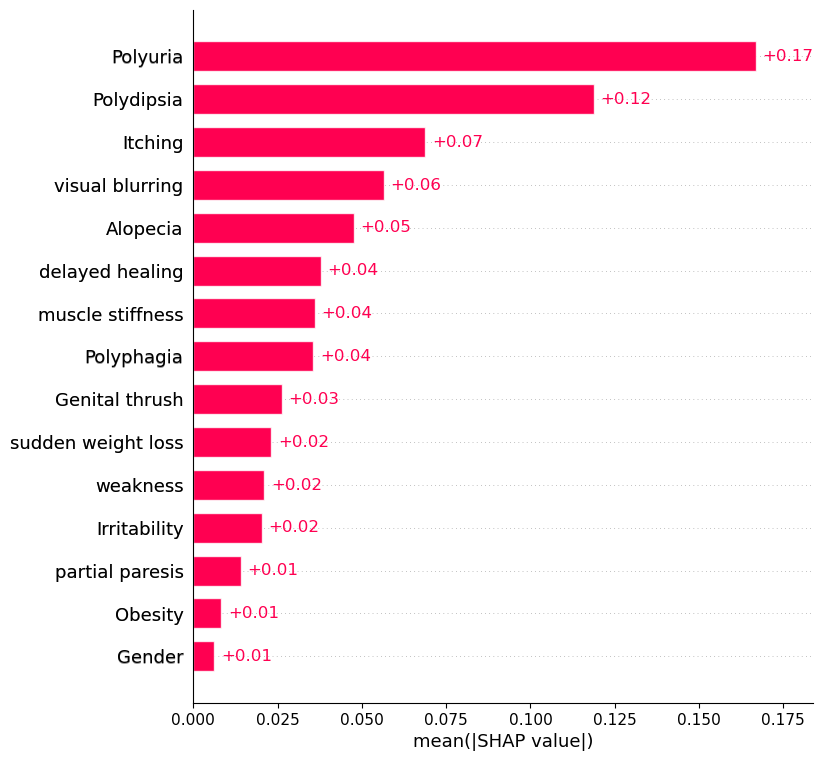

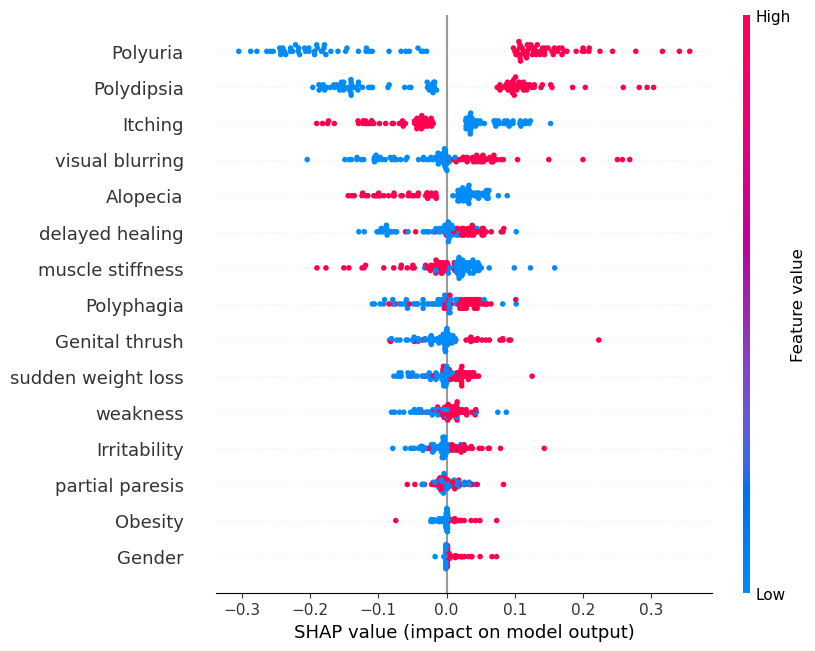

In [32]:
n = len(X_test)
explainer_g1 = shap.Explainer(model, X_test.values[0:n], algorithm='permutation')
shap_values = explainer_g1(X_test.values[0:n])
for i, c in enumerate(X_test.columns):
    shap_values.feature_names[i] = c
shap_values.data = X_test.values[0:n]

# Visualize SHAP Values
shap.plots.bar(shap_values, max_display=30)
shap.plots.beeswarm(shap_values, max_display=30)